## Objective and OverView

**Objective** : Modify Verterbi algorithm to take care of Unknow words <br><br>

**Steps followed**:
1. Data Preparation
2. Exploratory data Analysis
3. Spliting into Train and Validation set
4. Building Vanlia Verterbi Model and evaluting on validation set
5. Solving problems for unknow words
    - Method 1: Transitional Probability
    - Method 2 : Lexicon and Rule Based Method
6. Evaluting on the sample test sentences
7. Comparing Accuracy with Vanilia Model
8. Showcasing correctly POS tagged words with modified Verterbi

## Data Preparation

In [1]:
#Importing libraries

import nltk
from collections import Counter
from sklearn.model_selection import train_test_split
import random

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import pprint, time

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

In [2]:
# reading the Treebank tagged sentences

nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# Viewing three tagged sentences
# This will be in the form of list of tuples

nltk_data[:3]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

In [4]:
# converting the list of sents to a list of (word, pos tag) tuples

tagged_words = [tup for sentence in nltk_data for tup in sentence]

# Printing number of tagged words
print('Number of Tagged Words are: {}'.format(len(tagged_words)))
print('-'*127)

# Viewing some sample tagged words
tagged_words[:10]

Number of Tagged Words are: 100676
-------------------------------------------------------------------------------------------------------------------------------


[('Pierre', 'NOUN'),
 ('Vinken', 'NOUN'),
 (',', '.'),
 ('61', 'NUM'),
 ('years', 'NOUN'),
 ('old', 'ADJ'),
 (',', '.'),
 ('will', 'VERB'),
 ('join', 'VERB'),
 ('the', 'DET')]

We now have a list of about 100676 (word, tag) tuples. Let's now do some exploratory analyses.

## EDA

In [5]:
# Let's see how many unique tags are there

tags = [pair[1] for pair in tagged_words]
unique_tags = set(tags)
print('Number of Unique Tags:{}'.format(len(unique_tags)))

Number of Unique Tags:12


In [6]:
# Most frequent tags in the corpus

tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 28867,
         '.': 11715,
         'NUM': 3546,
         'ADJ': 6397,
         'VERB': 13564,
         'DET': 8725,
         'ADP': 9857,
         'CONJ': 2265,
         'X': 6613,
         'ADV': 3171,
         'PRT': 3219,
         'PRON': 2737})

In [7]:
# Top 5 most frequently used tags

print(tag_counts.most_common(5))

[('NOUN', 28867), ('VERB', 13564), ('.', 11715), ('ADP', 9857), ('DET', 8725)]


Thus, NOUN is the most common tag followed by VERB, .(Puncuation), Adpositions(Preposition and Posposition) and DETERMINERS.

## Splitting into Train and Validation Set

In [8]:
# Spilting the data into train and validation set the given ratio is 95:5

# Setting the random seed so that we get same results

# We will be naming validation set as test set

random.seed(1234)

#Spliting
train_set, test_set = train_test_split(nltk_data, test_size = 0.05, random_state = 42)

print('Training data Length:', len(train_set))
print('Test data Length:', len(test_set))
print('-'*127)

# Viewing sample of training data
print('Training set sample: \n',train_set[:2])

Training data Length: 3718
Test data Length: 196
-------------------------------------------------------------------------------------------------------------------------------
Training set sample: 
 [[('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ("'s", 'PRT'), ('shares', 'NOUN'), ('are', 'VERB'), ('traded', 'VERB'), ('*-1', 'X'), ('on', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('of', 'ADP'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('due', 'ADJ'), ('1991-2000', 'NUM'), ('and', 'CONJ'), ('2009', 'NUM'), (',', '.'), ('tentatively', 'ADV'), ('priced', 'VERB'), ('*', 'X'), ('by', 'ADP'), ('a', 'DET'), ('Chemical', 'NOUN'), ('Securities', 'NOUN'), ('Inc.', 'NOUN'), ('group', 'NOUN'), ('*', 'X'), ('to', 'PRT'), ('yield', 'VERB'), ('from', 'ADP'), ('6

## Continuing Exploratory Analysis on training data

In [9]:
# Number of tagged words in training data

tagged_words_train = [tup for sentence in train_set for tup in sentence]
print('Length of training tagged words: ', len(tagged_words_train))

print('-'*127)

# Viewing tagged words

tagged_words_train[:10]

Length of training tagged words:  95589
-------------------------------------------------------------------------------------------------------------------------------


[('Bank', 'NOUN'),
 ('of', 'ADP'),
 ('New', 'NOUN'),
 ('England', 'NOUN'),
 ("'s", 'PRT'),
 ('shares', 'NOUN'),
 ('are', 'VERB'),
 ('traded', 'VERB'),
 ('*-1', 'X'),
 ('on', 'ADP')]

In [10]:
# Let's see how many unique words and tags are there

train_words = [pair[0] for pair in tagged_words_train]
train_tags = [pair[1] for pair in tagged_words_train]

unique_tags = set(train_tags)
unique_words = set(train_words)

print('Number of Unique Tags:{}'.format(len(unique_tags)))
print('Number of Unique Words:{}'.format(len(unique_words)))

Number of Unique Tags:12
Number of Unique Words:12109


In [11]:
# Number of tokens which are unique i.e. Vocabulary and also tags
# Storing them in the varaible V and T

V = set(train_words) # Vocabulary 
T = set(train_tags)  # Tags

In [12]:
# We will convert the training vocabulary words to a list as it a set

training_vocab_words = list(V)

## Build the vanilla Viterbi based POS tagger

In [13]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [14]:
# compute word given tag: Emission Probability

def word_given_tag(word, tag, train_bag = tagged_words_train):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [15]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = tagged_words_train):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1]==t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype = 'float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)):
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [17]:
# convert the matrix to a df for better readability

tags_df = pd.DataFrame(tags_matrix, columns = list(T), index = list(T))
tags_df

,PRON,NUM,NOUN,ADP,X,CONJ,ADJ,ADV,VERB,DET,PRT,.
PRON,0.008021,0.007257,0.211230,0.022918,0.092819,0.004966,0.074866,0.033995,0.480901,0.009549,0.012223,0.041253
NUM,0.001487,0.184062,0.355338,0.034790,0.206661,0.013381,0.034196,0.002974,0.017544,0.003271,0.027951,0.118347
NOUN,0.004923,0.009627,0.264632,0.176275,0.029136,0.041936,0.012289,0.016884,0.147978,0.013310,0.043832,0.239179
ADP,0.069128,0.062921,0.321776,0.017228,0.034029,0.000856,0.105297,0.013162,0.008240,0.326378,0.001498,0.039486
X,0.056087,0.002709,0.061345,0.142925,0.076482,0.010357,0.016571,0.025175,0.203633,0.055131,0.185787,0.163799
CONJ,0.058658,0.042234,0.349132,0.054435,0.007977,0.000469,0.116847,0.055842,0.153918,0.121539,0.004693,0.034256
ADJ,0.000658,0.020405,0.696725,0.078986,0.021392,0.016949,0.066645,0.004608,0.012342,0.005101,0.010861,0.065328
ADV,0.015615,0.030565,0.030897,0.119601,0.023588,0.006312,0.130233,0.081063,0.344518,0.067110,0.013621,0.136877
VERB,0.036244,0.022817,0.110904,0.090493,0.218005,0.005588,0.064649,0.082577,0.169189,0.133101,0.031121,0.035312
DET,0.003742,0.021970,0.640029,0.009054,0.045509,0.000483,0.204973,0.012313,0.038387,0.005311,0.000241,0.017986


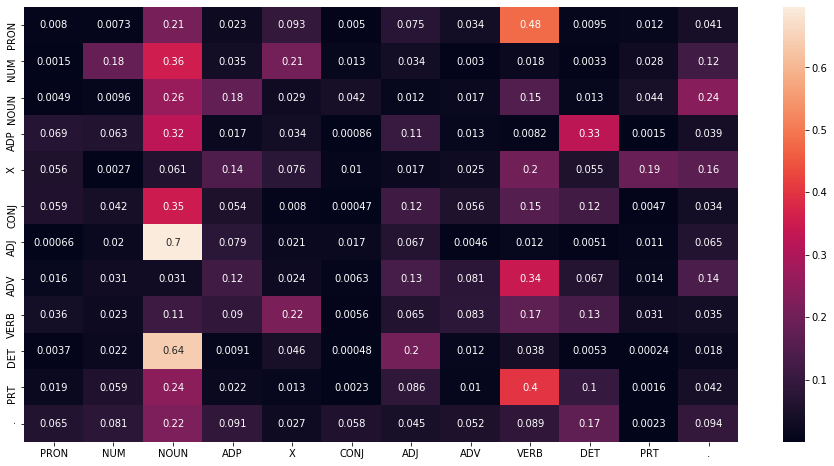

In [18]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)

plt.figure(figsize=(16, 8))
sns.heatmap(tags_df, annot = True)
plt.show()

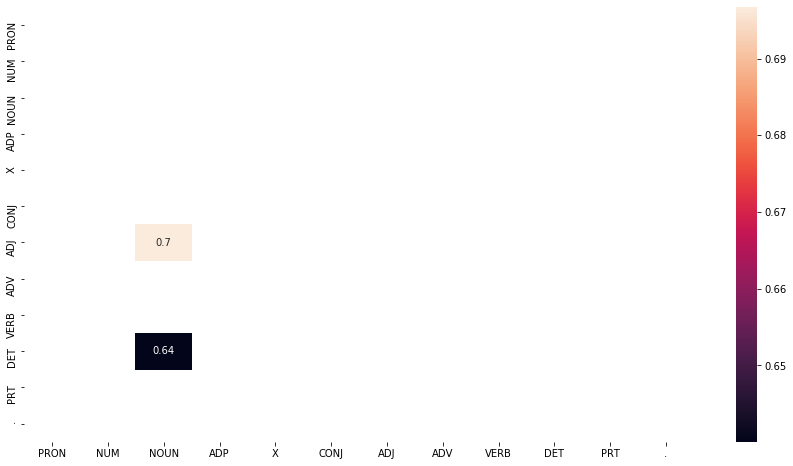

In [19]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5

tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(15, 8))
sns.heatmap(tags_frequent, annot = True)
plt.show()

In [20]:
# Vanlila Viterbi Heuristic

def Viterbi(words, train_bag = tagged_words_train):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [21]:
# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
len(test_tagged_words)

5087

In [22]:
test_tagged_words

['For',
 'the',
 'Agency',
 'for',
 'International',
 'Development',
 ',',
 'appropriators',
 'approved',
 '$',
 '200',
 'million',
 '*U*',
 'in',
 'secondary',
 'loan',
 'guarantees',
 'under',
 'an',
 'expanded',
 'trade',
 'credit',
 'insurance',
 'program',
 ',',
 'and',
 'total',
 'loan',
 'guarantees',
 'for',
 'the',
 'Overseas',
 'Private',
 'Investment',
 'Corp.',
 'are',
 'increased',
 '*-3',
 'by',
 '$',
 '40',
 'million',
 '*U*',
 'over',
 'fiscal',
 '1989',
 'as',
 'part',
 'of',
 'the',
 'same',
 'Poland',
 'package',
 '.',
 'The',
 'market',
 'is',
 'just',
 'becoming',
 'more',
 'efficient',
 '.',
 "''",
 'Moscow',
 'has',
 'settled',
 'pre-1917',
 'debts',
 'with',
 'other',
 'countries',
 'in',
 'recent',
 'years',
 'at',
 'less',
 'than',
 'face',
 'value',
 '.',
 '``',
 'Unemployment',
 'continues',
 'at',
 'a',
 'relatively',
 'low',
 'level',
 ',',
 '*',
 'providing',
 'a',
 'sense',
 'of',
 'job',
 'security',
 ',',
 'and',
 'a',
 'low',
 'inflation',
 'rate',
 '

In [23]:
# tagging the test sentences and measuring time

start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  1459.5523574352264


In [24]:
# Checking the accuracy of Vanilla Verterbi

check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy_0 = round(len(check)/len(tagged_seq),2)
print('Accuray of Vanilla Verterbi:', accuracy_0)

Accuray of Vanilla Verterbi: 0.91


In [25]:
# Looking at all the inncorrectly tagged words

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
print('Incorrectly tagged words are:',len(incorrect_tagged_cases))

Incorrectly tagged words are: 442


## Solving the problem of unknown words

### Method 1: Transitional Probability

In [26]:
# Modifying the Verterbi algorithim refercing to transitional proability


# Viterbi Heuristic_M1

def Viterbi_M1(words, train_bag = tagged_words_train):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
               
            # Changing the algorithim to understand unknown words
            # i.e. if the word is unkown we will considering only transitional probaililtiy
            
            if word not in training_vocab_words:
                state_probability = transition_p
            else:
                state_probability = emission_p * transition_p
        
            p.append(state_probability)
            
        pmax = max(p)
        state_max = T[p.index(pmax)]
              
        state.append(state_max)
    return list(zip(words, state))

In [27]:
# tagging the test sentences and measring time

start = time.time()
tagged_seq_1 = Viterbi_M1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  949.0630171298981


In [28]:
# Checking the accuracy of Modified Veterbi using Method 2

check = [i for i, j in zip(tagged_seq_1, test_run_base) if i == j] 
accuracy_1 = round(len(check)/len(tagged_seq_1),2)
print('Accuray of  Modified Veterbi using Method 2:', accuracy_1)

Accuray of  Modified Veterbi using Method 2: 0.94


In [29]:
# Looking at all the inncorrectly tagged words

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_1, test_run_base)) if j[0]!=j[1]]
print('Incorrectly tagged words Using Method 1:',len(incorrect_tagged_cases))

Incorrectly tagged words Using Method 1: 311


### Method 2: Using Lexicon and Rule based taggers

In [30]:
# specify patterns for tagging


patterns = [
    (r'.*ness$', 'NOUN'),             # Possesive Noun
    (r'.*\'s$', 'NOUN'),              # Possesive Noun
    (r'.*s$', 'NOUN'),                # Plural Noun
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'), #Determinant
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'), # Adjective
    (r'.*able$', 'ADJ'),                     # Adjective
    (r'.*', 'NOUN')                   # nouns
    
]


# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

# lexicon backed up by the rule-based tagger
lexicon_tagger = nltk.UnigramTagger(train_set, backoff=rule_based_tagger)

print(round(lexicon_tagger.evaluate(test_set),2))

0.96


In [31]:
# defining a function to use the rules which we have defined above

def lexicon_rule_based(word):
    patterns = [
    (r'.*ness$', 'NOUN'),             # Possesive Noun
    (r'.*\'s$', 'NOUN'),              # Possesive Noun
    (r'.*s$', 'NOUN'),                # Plural Noun
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'(The|the|A|a|An|an)$', 'DET'), #Determinant
    (r'^([0-9]|[aA-zZ])+\-[aA-zZ]*$','ADJ'), # Adjective
    (r'.*able$', 'ADJ'),                     # Adjective
    (r'.*', 'NOUN')                   # nouns
    
]
    rule_based_tagger = nltk.RegexpTagger(patterns)
    tag = rule_based_tagger.tag([word.lower()])[0][1]
    return tag

In [32]:
# Modifying the Verterbi algorithim using the above function


# Viterbi Heuristic_M2

def Viterbi_M2(words, train_bag = tagged_words_train):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        
        if word not in training_vocab_words and pmax == 0.0:
            state_max = lexicon_rule_based(word)
        else:
            state_max = T[p.index(pmax)]
              
        state.append(state_max)
    return list(zip(words, state))

In [33]:
# tagging the test sentences and measuring time

start = time.time()
tagged_seq_2 = Viterbi_M2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)

Time taken in seconds:  653.5820600986481


In [34]:
# Checking the accuracy of Modified Veterbi using Method 1

check = [i for i, j in zip(tagged_seq_2, test_run_base) if i == j] 
accuracy_2 = round(len(check)/len(tagged_seq_2),2)
print('Accuray of  Modified Veterbi using Method 1:', accuracy_2)

Accuray of  Modified Veterbi using Method 1: 0.96


In [35]:
# Looking at all the inncorrectly tagged words

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq_2, test_run_base)) if j[0]!=j[1]]
print('Incorrectly tagged words Using Method 2:',len(incorrect_tagged_cases))

Incorrectly tagged words Using Method 2: 217


## Running the Veterbi on sample test sentences

In [36]:
# Reading the test sentences txt file

test_sentences = open('Test_sentences.txt', mode = 'r').read()
print(test_sentences)

Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite.






In [37]:
# Tokenizing them into sentences

sample_sent = sent_tokenize(test_sentences)

In [38]:
# Word Tokenizing

word_tokenize_M2 = word_tokenize(test_sentences)

In [39]:
# Tokenizing the words

words_ts = [word_tokenize(sentence) for sentence in sample_sent]

In [40]:
# Tagging the test sentences with POS tag to measure accuracy 

words_tag_ts = nltk.pos_tag_sents(words_ts, tagset = 'universal')

In [41]:
# list of tagged words
sample_run_base = [tup for sent in words_tag_ts for tup in sent]

# list of untagged words
sample_tagged_words = [tup[0] for sent in words_tag_ts for tup in sent]
len(sample_tagged_words)

181

In [42]:
# Storing Unkown words

unknown_words = [word for word in word_tokenize_M2 if word not in V]
unknown_words

['Android',
 'Google',
 'Android',
 'OS',
 'worldwide',
 'smartphones',
 '2011',
 '2013',
 'Google',
 'Twitter',
 '2015',
 'Google',
 'Twitter',
 'firehose',
 'Twitter',
 'online',
 'interact',
 'messages',
 'tweets',
 'domineering',
 'personality',
 '2018',
 'FIFA',
 'Cup',
 '21st',
 'FIFA',
 'Cup',
 'tournament',
 'contested',
 'Cup',
 'trips',
 'arriving',
 'NASA',
 'invited',
 'ICESAT-2',
 'Satellite']

#### Evaluting Vanilia Veterbi on sample sentences

In [43]:
# Appyling the Vanlia Verterbi to the test sentences and measuring time

start = time.time()
tagged_seq0 = Viterbi(words_ts)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round((difference),2))

Time taken in seconds:  1.3


In [44]:
# Checking the accuracy of Vanillia Veterbi one sample sentences

sample_vanilia_seq = Viterbi(sample_tagged_words)

check_vanilia = [i for i, j in zip(sample_vanilia_seq, sample_run_base) if i == j] 
accuracy_vanilia = round(len(check_vanilia)/len(sample_vanilia_seq ),2)
print('Accuray of  Vanilia Veterbi using Method 1:', accuracy_vanilia)

Accuray of  Vanilia Veterbi using Method 1: 0.76


#### Evaluting Method 1 on sample sentences

In [45]:
# Appyling the Method 1 to the test sentences and measuring time

start = time.time()
tagged_seq1 = Viterbi_M1(words_ts)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round((difference),2))

Time taken in seconds:  1.22


In [46]:
# Checking the accuracy of Method 1 one sample sentences

sample_M1_seq = Viterbi_M1(sample_tagged_words)

check_M1 = [i for i, j in zip(sample_M1_seq, sample_run_base) if i == j] 
accuracy_M1 = round(len(check_M1)/len(sample_M1_seq ),2)
print('Accuray of  Modified Veterbi using Method 1:', accuracy_M1)

Accuray of  Modified Veterbi using Method 1: 0.87


#### Evaluting Method 2 on sample sentences

In [47]:
# Appyling the Method 2 to the test sentences and measuring time

start = time.time()
tagged_seq2 = Viterbi_M2(word_tokenize_M2)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round((difference),2))

Time taken in seconds:  22.67


In [48]:
# Checking the accuracy of Method 1 one sample sentences

sample_M2_seq = Viterbi_M2(sample_tagged_words)

check_M2 = [i for i, j in zip(sample_M2_seq, sample_run_base) if i == j] 
accuracy_M2 = round(len(check_M2)/len(sample_M2_seq ),2)
print('Accuray of  Modified Veterbi using Method 1:', accuracy_M2)

Accuray of  Modified Veterbi using Method 1: 0.94


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [49]:
# Creating a dataframe to compare different accuracy

df = pd.DataFrame({'Tagging Method':['Vanilla Viterbi', 'Viterbi Method 1', 'Viterbi Method 2'],
                  'Validation Accuracy':[accuracy_0, accuracy_1, accuracy_2],
                  'Sample Test Sentence Accuracy':[accuracy_vanilia, accuracy_M1, accuracy_M2]})
df

,Tagging Method,Validation Accuracy,Sample Test Sentence Accuracy
0,Vanilla Viterbi,0.91,0.76
1,Viterbi Method 1,0.94,0.87
2,Viterbi Method 2,0.96,0.94


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [50]:
# Taking some sample cases to showcase the modification

sentence_1 = 'Before entering politics, Donald Trump was a domineering businessman and a television personality.'
sentence_2 = 'NASA invited social media users to experience the launch of ICESAT-2 Satellite.'
sentence_3 = 'Android is a mobile operating system developed by Google.'

In [51]:
# Case 1

# Tokenizing words
words_in_sentence_1 = word_tokenize(sentence_1)

# Tagging with Vanilia Veterbi
Vanilia_Veterbi_POS_1 = Viterbi(words_in_sentence_1)
print('Words tagged with Vanilia Viterbi\n\n',Vanilia_Veterbi_POS_1)

print('-'*127)


# Tagging with Transitional Proability method (M1)
M1_POS_1 = Viterbi_M1(words_in_sentence_1)
print('Words tagged with Method 1\n\n',M1_POS_1)

print('-'*127)

# Tagging with Lexicon Rule Based Tagger(Method2)
M2_POS_1 = Viterbi_M2(words_in_sentence_1)
print('Words tagged with Method 2\n\n',M2_POS_1)

Words tagged with Vanilia Viterbi

 [('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'PRON'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'PRON'), ('.', '.')]
-------------------------------------------------------------------------------------------------------------------------------
Words tagged with Method 1

 [('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'NOUN'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'NOUN'), ('.', '.')]
-------------------------------------------------------------------------------------------------------------------------------
Words tagged with Method 2

 [('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.')

1. Using method 1 we can see that:
    - **domineering** is converted to NOUN which was considered CONJ before
    - **personality** isconverted to NOUN which was considered CONJ before
 <br><br>
2. Using Method 2 we can see that:
    - **domineering** is converted to VERB which was considered CONJ before
    - **personality** isconverted to NOUN which was considered CONJ before

In [52]:
# Case 2

# Tokenizing words
words_in_sentence_2 = word_tokenize(sentence_2)

# Tagging with Vanilia Veterbi
Vanilia_Veterbi_POS_2 = Viterbi(words_in_sentence_2)
print('Words tagged with Vanilia Viterbi\n\n',Vanilia_Veterbi_POS_2)

print('-'*127)

# Tagging with Transitional Proability method (M1)
M1_POS_2 = Viterbi_M1(words_in_sentence_2)
print('Words tagged with Method 1\n\n',M1_POS_2)

print('-'*127)

# Tagging with Lexicon Rule Based Tagger(Method2)
M2_POS_2 = Viterbi_M2(words_in_sentence_2)
print('Words tagged with Method 2\n\n',M2_POS_2)

Words tagged with Vanilia Viterbi

 [('NASA', 'PRON'), ('invited', 'PRON'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'PRON'), ('Satellite', 'PRON'), ('.', '.')]
-------------------------------------------------------------------------------------------------------------------------------
Words tagged with Method 1

 [('NASA', 'NOUN'), ('invited', 'NOUN'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 'NOUN'), ('of', 'ADP'), ('ICESAT-2', 'DET'), ('Satellite', 'NOUN'), ('.', '.')]
-------------------------------------------------------------------------------------------------------------------------------
Words tagged with Method 2

 [('NASA', 'NOUN'), ('invited', 'VERB'), ('social', 'ADJ'), ('media', 'NOUN'), ('users', 'NOUN'), ('to', 'PRT'), ('experience', 'NOUN'), ('the', 'DET'), ('launch', 

1. Using method 1 we can see that:
    - **NASA** is converted to NOUN which was considered CONJ before
    - **invited** is converted to NOUN which was considered CONJ before
    - **ICESAT-2** isconverted to DET which was considered CONJ before
    - **Satellite** isconverted to NOUN which was considered CONJ before
<br><br>
2. Using Method 2 we can see that:
    - **NASA** is converted to NOUN which was considered CONJ before
    - **invited** is converted to VERB which was considered CONJ before
    - **ICESAT-2** isconverted to NOUN which was considered CONJ before
    - **Satellite** is converted to NOUN which was considered CONJ before

In [53]:
# Case 3

# Tokenizing words
words_in_sentence_3 = word_tokenize(sentence_3)

# Tagging with Vanilia Veterbi
Vanilia_Veterbi_POS_3 = Viterbi(words_in_sentence_3)
print('Words tagged with Vanilia Viterbi\n\n',Vanilia_Veterbi_POS_3)

print('-'*127)

# Tagging with Transitional Proability method (M1)
M1_POS_3 = Viterbi_M1(words_in_sentence_3)
print('Words tagged with Method 1\n\n',M1_POS_3)

print('-'*127)

# Tagging with Lexicon Rule Based Tagger(Method2)
M2_POS_3 = Viterbi_M2(words_in_sentence_3)
print('Words tagged with Method 2\n\n',M2_POS_3)

Words tagged with Vanilia Viterbi

 [('Android', 'PRON'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRON'), ('.', '.')]
-------------------------------------------------------------------------------------------------------------------------------
Words tagged with Method 1

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]
-------------------------------------------------------------------------------------------------------------------------------
Words tagged with Method 2

 [('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


1. Using method 1 we can see that:
    - **Android** is converted to NOUN which was considered CONJ before
    - **Google** is converted to DET which was considered CONJ before
<br><br>
2. Using Method 2 we can see that:
    - **Android** is converted to NOUN which was considered CONJ before
    - **Google** is converted to NOUN which was considered CONJ before

##### To conculde we can say that lexicon with rule based tagger perform better than the Vanillia Veterbi 